<a href="https://colab.research.google.com/github/ciromanzar/LaboDeDatos-TPFinal/blob/main/Labo_de_Datos_TP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e instalaciones

### Imports y lectura de FlavorDB

In [ ]:
!git clone https://github.com/fzamberlan/flavordb_tp

Cloning into 'flavordb_tp'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 19), reused 24 (delta 10), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [ ]:
! cd flavordb_tp; git pull

Already up to date.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.cluster import AgglomerativeClustering
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec
from itertools import combinations

In [ ]:
data = pd.read_csv("/content/flavordb_tp/FlavorDB JSONs to CSV.csv")
display(data)

,pubchem_id,common_name,iupac_name,smile,inchi,taste,odor,flavor_profile,fema_flavor_profile,fooddb_flavor_profile,bitter,super_sweet,bitterdb_id,flavornet_id,fooddb_id,supersweetdb_id,fema_number,cas_id,functional_groups,bond_stereo_count,undefined_atom_stereocenter_count,heavy_atom_count,hba_count,hbd_count,synthetic,natural,charge,isotope_atom_count,molecular_weight,fenoroli_and_os,exact_mass,volume3d,unknown_natural,covalently_bonded_unit_count,undefined_bond_stereocenter_count,num_rotatablebonds,defined_bond_stereocenter_count,xlogp,topological_polor_surfacearea,defined_atom_stereocenter_count,atom_stereo_count,complexity,monoisotopic_mass
0,4,1-Aminopropan-2-ol,1-aminopropan-2-ol,CC(CN)O,"InChI=1S/C3H9NO/c1-3(5)2-4/h3,5H,2,4H2,1H3",NaN,slight ammonia odor,fishy,NaN,fishy,0,NaN,NaN,0,FDB008936,NaN,3965,2799-17-9@78-96-6@2799-16-8,"hydroxy compound@alcohol@secondary alcohol@1,2...",0,1,5,2,2,0,1,0,0,75.111,1,75.068,63.3,0,1,0,1,0,-1.0,46.2,0,1,22.9,75.068
1,40,2-Deoxyhexopyranose,"6-(hydroxymethyl)oxane-2,4,5-triol",C1C(C(C(OC1O)CO)O)O,InChI=1S/C6H12O5/c7-2-4-6(10)3(8)1-5(9)11-4/h3...,NaN,NaN,sweet,NaN,NaN,0,Sweet,NaN,0,NaN,9189.0,NaN,14215-77-1,hemiacetal@hydroxy compound@alcohol@primary al...,0,4,11,5,4,0,0,0,0,164.157,0,164.068,116.0,0,1,0,1,0,-1.6,90.2,0,4,128.0,164.068
2,47,3-Methyl-2-oxovaleric acid,3-methyl-2-oxopentanoic acid,CCC(C)C(=O)C(=O)O,"InChI=1S/C6H10O3/c1-3-4(2)5(7)6(8)9/h4H,3H2,1-...",NaN,NaN,NaN,Fruit,NaN,0,NaN,NaN,0,NaN,NaN,3870,1460-34-0@39748-49-7,carbonyl compound@ketone@carboxylic acid deriv...,0,1,9,3,1,0,0,0,0,130.143,1,130.063,103.4,0,1,0,3,0,1.1,54.4,0,1,128.0,130.063
3,49,3-Methyl-2-oxobutanoic acid,3-methyl-2-oxobutanoic acid,CC(C)C(=O)C(=O)O,"InChI=1S/C5H8O3/c1-3(2)4(6)5(7)8/h3H,1-2H3,(H,...",NaN,NaN,fruity,NaN,fruity,0,NaN,NaN,0,FDB012250,NaN,3869,759-05-7,carbonyl compound@ketone@carboxylic acid deriv...,0,0,8,3,1,0,1,0,0,116.116,1,116.047,91.1,0,1,0,2,0,0.7,54.4,0,0,115.0,116.047
4,51,2-ketoglutaric acid,2-oxopentanedioic acid,C(CC(=O)O)C(=O)C(=O)O,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(...",NaN,NaN,odorless,NaN,odorless,0,NaN,NaN,0,FDB003361,NaN,3891,22202-68-2@328-50-7@17091-15-5@34410-46-3@997-...,carbonyl compound@ketone@carboxylic acid deriv...,0,0,10,5,2,0,0,0,0,146.098,1,146.022,105.7,0,1,0,4,0,-0.9,91.7,0,0,171.0,146.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,121460164,SCHEMBL17898401,NaN,CC12CCCC(C1CCC34C2CCC(C3)(C(=C)C4)OC5C(C(C(C(O...,"InChI=1S/C57H92O32/c1-20-12-56-9-5-29-54(2,7-4...",NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,22520.0,NaN,NaN,acetal@hydroxy compound@alcohol@primary alcoho...,0,32,89,32,20,1,0,0,0,1289.331,0,1288.557,NaN,0,1,0,19,0,-5.4,523.0,4,36,2400.0,1288.557
25591,121461316,SCHEMBL17899769,"(2S,4S,5S)-2-(2,3-dihydroxypropoxy)-6-(hydroxy...",C(C1C(C(C(C(O1)OCC(CO)O)O)O)O)O,InChI=1S/C9H18O8/c10-1-4(12)3-16-9-8(15)7(14)6...,NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,22203.0,NaN,NaN,acetal@hydroxy compound@alcohol@primary alcoho...,0,3,17,8,6,1,0,0,0,254.235,0,254.100,178.3,0,1,0,5,0,-3.4,140.0,3,6,225.0,254.100
25592,121463299,SCHEMBL17901912,NaN,CC12CCCC(C1CCC34C2CCC(C3)(C(=C)C4)OC5C(C(C(C(O...,"InChI=1S/C57H92O32/c1-20-12-56-9-5-29-54(2,7-4...",NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,22521.0,NaN,NaN,acetal@hydroxy compound@alcohol@primary alcoho...,0,31,89,32,20,1,0,0,0,1289.331,0,1288.557,NaN,0,1,0,19,0,-5.4,523.0,5,36,2400.0,1288.557
25593,121484514,SCHEMBL17926245,"(3S,4R,5S)-2-(6-aminopurin-9-yl)-5-(hydroxymet...",C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O,InChI=1S/C10H13N5O4/c11-8-5-9(13-2-12-8)15(3-1...,NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,33819.0,NaN,NaN,hydroxy compound@alcohol@primary alcohol@secon...,0,1,19,8,4,1,0,0,0,267.245,0,267.097,185.0,0,1,0,2,0,-1.1,140.0,3,4,335.0,267.097


### Librerias de descriptores de molécula

In [ ]:
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 


In [ ]:
from rdkit.Chem.inchi import MolFromInchi

mols = [MolFromInchi(inchi) for inchi in data.loc[:,'inchi']] 

In [ ]:
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem

def mol2fp(mol, radius=2, nBits=1024, useFeatures=True):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bitInfo, useFeatures=useFeatures)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr, bitInfo

fingerprints = []
for i in range(len(mols)):
  #print(i)
  if i != 18238: # Si se ejecuta antes de la limpieza de flavors es el 18238. Si se ejecuta despues es 17761
    fingerprints.append(mol2fp(mols[i])[0])
  else:
    fingerprints.append(np.zeros((1024,)))

fingerprints_dataframe = pd.DataFrame(np.stack(fingerprints))

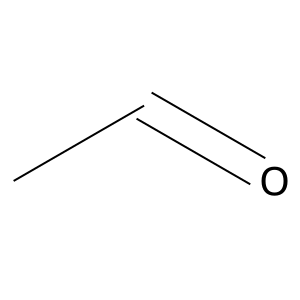

In [ ]:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D

def DrawMolecule(id, molSize=(300,300)):
  mol = mols[id]
  mc = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
  drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
  drawer.drawOptions().useBWAtomPalette()
  drawer.DrawMolecule(mc) #highlightAtoms=, highlightBonds=, highlightAtomColors=, highlightBondColors=, highlightAtomRadii=
  drawer.FinishDrawing()
  svg = drawer.GetDrawingText().replace('svg:','')
  display(SVG(svg))


DrawMolecule(15)


In [ ]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

descriptors_list = [x[0] for x in Descriptors._descList]
print(descriptors_list)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [ ]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)
mol_description = calculator.CalcDescriptors(mols[25])
print(mol_description)

(10.72513510873179, -4.718945679090431, 10.72513510873179, 0.14182226975832712, 0.3901785445724402, 347.22400000000005, 333.112, 347.06308441799996, 126, 0, 0.46917068506123866, -0.38741947596718945, 0.46917068506123866, 0.38741947596718945, 1.3043478260869565, 2.0434782608695654, 2.739130434782609, 31.204461967197073, 10.128387819411481, 2.4469399924882795, -2.1604085793861, 2.3835472459373603, -2.3318369701078807, 7.4583012987707455, -0.050352303091379245, 1.8511475274909786, 763.1378284373786, 16.77565640300939, 11.498225896405142, 12.392653087405057, 10.776675564742526, 6.423970871344677, 7.9542676146848965, 4.9155882441756695, 6.15494103536498, 3.4054149504271494, 3.8908355119419324, 2.3234894508463366, 2.6646052046520925, -1.6600000000000004, 165343.29018390202, 16.2067005901362, 5.760949153548598, 3.052763103574016, 128.30354975942075, 30.470408426148595, 30.155919955625706, 17.692941169337626, 0.0, 0.0, 7.822697123132171, 9.090846809503173, 19.516983847772956, 0.0, 0.0, 0.0, 0.

# Limpieza de flavor profiles y one hot encoding

Se borran campos sin datos

In [ ]:
data_idxs_borrados = data[data['flavor_profile'].isna()].index

Rename de flavors que significan lo mismo

In [ ]:
data.dropna(subset = ['flavor_profile'], inplace=True)
data.reset_index(drop=True, inplace=True)
data["flavor_profile"] = data.flavor_profile.str.replace("@", ", " )
categories_dict_tmp = pd.read_csv("/content/flavordb_tp/flavor_profiles_dic.csv",header=None,index_col=0, squeeze=True).T.to_dict()

categories_dict = { k:v.strip() for k, v in categories_dict_tmp.items()}
data['flavor_clean'] = data["flavor_profile"].replace(categories_dict, regex=True)

In [ ]:
display(data)

,pubchem_id,common_name,iupac_name,smile,inchi,taste,odor,flavor_profile,fema_flavor_profile,fooddb_flavor_profile,bitter,super_sweet,bitterdb_id,flavornet_id,fooddb_id,supersweetdb_id,fema_number,cas_id,functional_groups,bond_stereo_count,undefined_atom_stereocenter_count,heavy_atom_count,hba_count,hbd_count,synthetic,natural,charge,isotope_atom_count,molecular_weight,fenoroli_and_os,exact_mass,volume3d,unknown_natural,covalently_bonded_unit_count,undefined_bond_stereocenter_count,num_rotatablebonds,defined_bond_stereocenter_count,xlogp,topological_polor_surfacearea,defined_atom_stereocenter_count,atom_stereo_count,complexity,monoisotopic_mass,flavor_clean
0,4,1-Aminopropan-2-ol,1-aminopropan-2-ol,CC(CN)O,"InChI=1S/C3H9NO/c1-3(5)2-4/h3,5H,2,4H2,1H3",NaN,slight ammonia odor,fishy,NaN,fishy,0,NaN,NaN,0,FDB008936,NaN,3965,2799-17-9@78-96-6@2799-16-8,"hydroxy compound@alcohol@secondary alcohol@1,2...",0,1,5,2,2,0,1,0,0,75.111,1,75.068,63.3,0,1,0,1,0,-1.0,46.2,0,1,22.9,75.068,fish
1,40,2-Deoxyhexopyranose,"6-(hydroxymethyl)oxane-2,4,5-triol",C1C(C(C(OC1O)CO)O)O,InChI=1S/C6H12O5/c7-2-4-6(10)3(8)1-5(9)11-4/h3...,NaN,NaN,sweet,NaN,NaN,0,Sweet,NaN,0,NaN,9189.0,NaN,14215-77-1,hemiacetal@hydroxy compound@alcohol@primary al...,0,4,11,5,4,0,0,0,0,164.157,0,164.068,116.0,0,1,0,1,0,-1.6,90.2,0,4,128.0,164.068,sweet
2,49,3-Methyl-2-oxobutanoic acid,3-methyl-2-oxobutanoic acid,CC(C)C(=O)C(=O)O,"InChI=1S/C5H8O3/c1-3(2)4(6)5(7)8/h3H,1-2H3,(H,...",NaN,NaN,fruity,NaN,fruity,0,NaN,NaN,0,FDB012250,NaN,3869,759-05-7,carbonyl compound@ketone@carboxylic acid deriv...,0,0,8,3,1,0,1,0,0,116.116,1,116.047,91.1,0,1,0,2,0,0.7,54.4,0,0,115.0,116.047,fruit
3,51,2-ketoglutaric acid,2-oxopentanedioic acid,C(CC(=O)O)C(=O)C(=O)O,"InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(...",NaN,NaN,odorless,NaN,odorless,0,NaN,NaN,0,FDB003361,NaN,3891,22202-68-2@328-50-7@17091-15-5@34410-46-3@997-...,carbonyl compound@ketone@carboxylic acid deriv...,0,0,10,5,2,0,0,0,0,146.098,1,146.022,105.7,0,1,0,4,0,-0.9,91.7,0,0,171.0,146.022,odorless
4,58,2-oxobutanoic acid,2-oxobutanoic acid,CCC(=O)C(=O)O,"InChI=1S/C4H6O3/c1-2-3(5)4(6)7/h2H2,1H3,(H,6,7)",NaN,NaN,"brown, caramel, lactonic, sweet, creamy",Savory,brown@caramel@lactonic@sweet@creamy,0,NaN,NaN,0,FDB003359,NaN,3723,600-18-0,carbonyl compound@ketone@carboxylic acid deriv...,0,0,7,3,1,0,1,0,0,102.089,1,102.032,78.5,0,1,0,2,0,0.1,54.4,0,0,95.1,102.032,"brown, caramel, lactone, sweet, cream"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25101,121460164,SCHEMBL17898401,NaN,CC12CCCC(C1CCC34C2CCC(C3)(C(=C)C4)OC5C(C(C(C(O...,"InChI=1S/C57H92O32/c1-20-12-56-9-5-29-54(2,7-4...",NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,22520.0,NaN,NaN,acetal@hydroxy compound@alcohol@primary alcoho...,0,32,89,32,20,1,0,0,0,1289.331,0,1288.557,NaN,0,1,0,19,0,-5.4,523.0,4,36,2400.0,1288.557,sweet
25102,121461316,SCHEMBL17899769,"(2S,4S,5S)-2-(2,3-dihydroxypropoxy)-6-(hydroxy...",C(C1C(C(C(C(O1)OCC(CO)O)O)O)O)O,InChI=1S/C9H18O8/c10-1-4(12)3-16-9-8(15)7(14)6...,NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,22203.0,NaN,NaN,acetal@hydroxy compound@alcohol@primary alcoho...,0,3,17,8,6,1,0,0,0,254.235,0,254.100,178.3,0,1,0,5,0,-3.4,140.0,3,6,225.0,254.100,sweet
25103,121463299,SCHEMBL17901912,NaN,CC12CCCC(C1CCC34C2CCC(C3)(C(=C)C4)OC5C(C(C(C(O...,"InChI=1S/C57H92O32/c1-20-12-56-9-5-29-54(2,7-4...",NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,22521.0,NaN,NaN,acetal@hydroxy compound@alcohol@primary alcoho...,0,31,89,32,20,1,0,0,0,1289.331,0,1288.557,NaN,0,1,0,19,0,-5.4,523.0,5,36,2400.0,1288.557,sweet
25104,121484514,SCHEMBL17926245,"(3S,4R,5S)-2-(6-aminopurin-9-yl)-5-(hydroxymet...",C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O,InChI=1S/C10H13N5O4/c11-8-5-9(13-2-12-8)15(3-1...,NaN,NaN,sweet-like,NaN,NaN,0,Sweet-like,NaN,0,NaN,33819.0,NaN,NaN,hydroxy compound@alcohol@primary alcohol@secon...,0,1,19,8,4,1,0,0,0,267.245,0,

In [ ]:
one_hot_encoding = data.flavor_clean.str.get_dummies(sep=", ")
categories = pd.DataFrame(one_hot_encoding.columns.values)
print(categories)

                0
0        absolute
1          acacia
2          acetic
3         acetone
4    acetophenone
..            ...
518       winegar
519    winterleaf
520          wood
521         yeast
522         ylang

[523 rows x 1 columns]


Cantidad de flavors que estan en menos de n moleculas

In [ ]:
print(one_hot_encoding.apply(pd.value_counts)[1:].T.sort_values(by=1).value_counts()[0:14], '\n')
print('Total: ',one_hot_encoding.apply(pd.value_counts)[1:].T.sort_values(by=1).value_counts()[0:14].sum())

1 
1     163
2      70
3      37
4      29
5      18
6      13
9      12
7      11
11      9
8       8
12      8
17      8
10      6
15      5
dtype: int64 

Total:  397


Sin flavors poco frecuentes y sin moleculas sin flavor

In [ ]:
columnasBye = one_hot_encoding.apply(pd.value_counts)[1:].T[one_hot_encoding.apply(pd.value_counts)[1:].T[1] < 14].index

oneHot_2 = one_hot_encoding.drop(columnasBye, axis=1)
oneHot_2['sumFlavors'] = one_hot_encoding.sum(axis=1)

No queda ninguna molecula sin flavor, sinó la borraría

In [ ]:
print(len(oneHot_2[oneHot_2['sumFlavors']==0].index))
#oneHot_2 = oneHot_2[oneHot_2['sumFlavors']>0]


0


# Scraping de thegoodscentscompany.com. Word2vec de flavors

In [ ]:
flavors_tgsc = data = pd.read_csv('/content/flavordb_tp/scrap_thegoodscents.csv', header=None)
flavors_tgsc[0] = flavors_tgsc[0].replace(categories_dict, regex=True)

In [ ]:
input = [row.split() for row in flavors_tgsc[0].to_list()] 

phrases = Phrases(input, min_count=30, progress_per=1000) 

bigram = Phraser(phrases)

sentences = bigram[input] 

In [ ]:
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=5, # ignora palabras cuya frecuencia es menor a esta
                     window=10, # tamanio de la ventana de contexto
                     size=300, # dimension del embedding
                     sample=4e-4, # umbral para downsamplear palabras muy frecuentes
                     alpha=0.05, # tasa de aprendizaje inicial (entrenamiento de la red neuronal)
                     min_alpha=0.0007, # tasa de aprendizaje minima
                     negative=50, # penalidad de palabras muy frecuentes o poco informaitvas
                     workers=cores) # numero de cores para entrenar el modelo

w2v_model.build_vocab(sentences, progress_per=10000) # construye el vocabulario

### ENTRENA EL MODELO
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
### PRECOMPUTA DISTANCIAS (mas rapido)
w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=["wax"])

[('soap', 0.8785505294799805),
 ('oil', 0.8195858001708984),
 ('fat', 0.8024465441703796),
 ('tallow', 0.7923926711082458),
 ('hairy', 0.7921764850616455),
 ('cantaloupe', 0.7683174014091492),
 ('melon', 0.7319305539131165),
 ('lard', 0.730401873588562),
 ('cucumber', 0.7201762199401855),
 ('watery', 0.7006985545158386)]

Soap: 0.885
Oil: 0.823
Fat: 0.806
Tallow: 0.799
Lard: 0.735

In [ ]:
print(w2v_model.wv.similarity('garlic', 'mustard'))

0.8643804


In [ ]:
print(w2v_model.wv.n_similarity(["garlic", "onion", "sulfur", "cabbage"],["sweet", "musk", "soap", "balsam"]))
print(w2v_model.wv.n_similarity(["garlic", "onion", "sulfur", "cabbage"],["lavender", "lime", "peppermint", "maple", "fusel"]))

-0.1369834
0.1531724


Funciones para medir que tan buena es una división en clusters

In [ ]:
def similaridad_de_cluster(flavors, primeros_n):
  flavors_en_w2v = [x for x in flavors if x in w2v_model.wv.vocab]
  if len(flavors_en_w2v) <= 1:
    return 0

  n = min(primeros_n, len(flavors_en_w2v))
  flavors_en_w2v = flavors_en_w2v[0:n]
  suma_similaridad = 0
  combinaciones = list(combinations(flavors_en_w2v,2))
  for pair in combinaciones:
    suma_similaridad += w2v_model.wv.similarity(pair[0], pair[1])

  return suma_similaridad / len(combinaciones)

def similaridad_entre_clusters(cluster1, cluster2, primeros_n):
  cluster1_en_w2v = [x for x in cluster1 if x in w2v_model.wv.vocab]
  cluster1_en_w2v = cluster1_en_w2v[:min(primeros_n, len(cluster1_en_w2v))]
  cluster2_en_w2v = [x for x in cluster2 if x in w2v_model.wv.vocab]
  cluster2_en_w2v = cluster2_en_w2v[:min(primeros_n, len(cluster2_en_w2v))]

  return w2v_model.wv.n_similarity(cluster1_en_w2v, cluster2_en_w2v)

def indice_falopa_clusters(clusters, primeros_n):
  promedio_clusters = np.mean([similaridad_de_cluster(cluster,primeros_n) for cluster in clusters]) 
  promedio_entre_clusters = np.mean([similaridad_entre_clusters(pair[0],pair[1], primeros_n) for pair in list(combinations(clusters,2))])
  # print(promedio_clusters)
  # print(promedio_entre_clusters)
  if promedio_entre_clusters <= 0:
    promedio_entre_clusters = .1
  return promedio_clusters/promedio_entre_clusters

In [ ]:
cluster0 = ["bland","musk","sweet", "bitter", "soap", "balsam", "mild","cream","camphor", "powdery","phenol","odorless","spicy","fruit","milk","fat"]
cluster1 = ["lavender", "tonka","alkaline","lime", "peppermint", "lactone","maple","powerful", "fusel","fennel","licorice","cedar","caraway","tallow","turpentine","baked","brandy","mandarin","moss"]
cluster2 = ["cassia","deep","cummin","faint","sweet","cabbage","odorless","sour","rancid","bitter","cinnamon","mild","sulfur","fruit"]
cluster3 = ["garlic", "onion","sulfur", "cabbage", "cooked","radish","gassy", "mustard", "alliaceous","tomato", "roast", "chip","egg","horseradish","savory","meat","buchu","chicken","aromatic"]
clusters = [cluster0,cluster1,cluster2,cluster3]

n=5
print("indice:",indice_falopa_clusters(clusters,n))

print("cluster0:",similaridad_de_cluster(cluster0,n))
print("cluster1:",similaridad_de_cluster(cluster1,n))
print("cluster2:",similaridad_de_cluster(cluster2,n))
print("cluster3:",similaridad_de_cluster(cluster3,n))

print("0 vs 1:",similaridad_entre_clusters(cluster0,cluster1,n))
print("0 vs 2:",similaridad_entre_clusters(cluster0,cluster2,n))
print("0 vs 3:",similaridad_entre_clusters(cluster0,cluster3,n))
print("1 vs 2:",similaridad_entre_clusters(cluster1,cluster2,n))
print("1 vs 3:",similaridad_entre_clusters(cluster1,cluster3,n))
print("2 vs 3:",similaridad_entre_clusters(cluster2,cluster3,n))

indice: 1.0887119532115122
cluster0: 0.3903528040274978
cluster1: 0.2605390854179859
cluster2: 0.29793617873219774
cluster3: 0.8829277217388153
0 vs 1: 0.73145545
0 vs 2: 0.6622378
0 vs 3: 0.15084715
1 vs 2: 0.6549348
1 vs 3: -0.08964405
2 vs 3: 0.4139159


# Algunas Stats

### Flavors más repetidos

In [ ]:
print(oneHot_2.iloc[: , 0: -1].apply(pd.value_counts)[1:].T.sort_values(by=1, ascending = False)[0:50])
#print(oneHot_2.iloc[: , 0: -1].apply(pd.value_counts)[1:].T.sort_values(by=1, ascending = True )[0:20])
#print(data[data['flavor_clean'].str.contains("meat gravey")][['flavor_profile', 'flavor_clean']])
#print(data[data['flavor_profile'].str.contains("beef,")][['flavor_profile', 'flavor_clean']])

# oneHot_2.columns[np.nonzero(oneHot_2.iloc[1, 0: -1].values)].values.tolist()

               1
sweet      22598
bitter       738
leaf         707
fruit        677
flower       336
wood         255
wax          219
spicy        215
fat          207
sulfur       169
odorless     163
nut          163
fresh        158
citric       140
apple        140
earth        139
balsam       137
oil          129
meat         128
roast        127
rose         127
tropicall    108
mint         101
pineapple     97
musty         96
vegetable     91
cream         87
caramel       87
mild          84
ether         81
phenol        76
onion         74
pungent       70
berry         69
powdery       69
honey         67
camphor       66
wine          65
butter        63
banana        62
garlic        59
vanilla       58
pear          58
coconut       56
orange        55
cheese        55
metal         52
almond        51
dry           49
melon         49


### Moleculas con tag 'sweet' pero que no es el único tag

In [ ]:
# oneHot_2[(oneHot_2['sweet'] == 1) & (oneHot_2['sumFlavors'] > 1)]
oneHot_2[oneHot_2['aldehydic'] == 1]

,acid,alcohol,aldehydic,alkaline,alliaceous,almond,amber,ammonia,animal,anise,apple,balsam,banana,bergamot,berry,bitter,bland,bread,burnt,butter,cabbage,camphor,caramel,celery,cheese,chemical,cherry,chocolate,cinnamon,citric,clean,clove,cocoa,coconut,coffee,cognac,cooked,cool,coumarin,cream,...,pineapple,plastic,plum,potato,powdery,powerful,pungent,rancid,raspberry,roast,rose,rotten,rum,savory,sharp,smoke,soap,solvent,sour,spicy,strawberry,strong,sulfur,sweat,sweet,tea,terpene,tobacco,tomato,tonka,tropicall,vanilla,vegetable,violet,warm,wax,weedy,wine,wood,sumFlavors
14,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
56,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8
97,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,9
323,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
365,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
537,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8
539,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11
606,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,6
619,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8
631,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8


# Ingeniería de features

In [ ]:
descriptoresRDKit_1 = pd.read_csv("/content/flavordb_tp/descriptoresRDKit_1.csv")
descriptoresRDKit_2 = pd.read_csv("/content/flavordb_tp/descriptoresRDKit_2.csv")
descriptoresRDKit = pd.concat([descriptoresRDKit_1, descriptoresRDKit_2])
descriptoresRDKit.reset_index(drop=True, inplace=True)

fp_dataframe = fingerprints_dataframe.copy()
mols2 = mols.copy()

Borro moleculas borradas en la limpieza de flavors

In [ ]:
descriptoresRDKit.drop(index=data_idxs_borrados, inplace=True)
descriptoresRDKit.reset_index(drop=True, inplace=True)

fp_dataframe.drop(index=data_idxs_borrados, inplace=True)
fp_dataframe.reset_index(drop=True, inplace=True)

In [ ]:
for idx in reversed(data_idxs_borrados.values.tolist()):
  del mols2[idx]

Borro molecula con descriptores rotos de df de features y el oneHot

In [ ]:
print(descriptoresRDKit.iloc[17761][1])
descriptoresRDKit.drop(17761,inplace=True)
#descriptoresRDKit.iloc[17761]

descriptoresRDKit.reset_index(drop=True, inplace=True)
descriptoresRDKit = descriptoresRDKit.iloc[:,1:]

#print(MolFromInchi(data.iloc[17761].inchi))
oneHot_2.drop(17761,inplace=True)
oneHot_2.reset_index(drop=True, inplace=True)
oneHot_2 = oneHot_2.iloc[:,1:]

print(fp_dataframe.iloc[17761][0])
fp_dataframe.drop(17761,inplace=True)
fp_dataframe.reset_index(drop=True, inplace=True)

#data.drop(17761,inplace=True)
#data.reset_index(drop=True, inplace=True)

-666.0
0.0


In [ ]:
del mols2[17761]

In [ ]:
fp_dataframe.rename(columns=lambda c: (c if type(c)==str else 'fp_'+str(int(c))), inplace=True)
features_RDKit_fp = pd.concat([descriptoresRDKit, fp_dataframe], axis=1)

Busco correlaciones entre features para eliminar redundantes

In [ ]:
correlation_mat = descriptoresRDKit.corr()
# correlation_mat

Busco descriptores sin info (igual para todas las moleculas)

In [ ]:
descrip_aBorrar = set(features_RDKit_fp.T[features_RDKit_fp.min() == features_RDKit_fp.max()].index)

print(len(descrip_aBorrar))
print(descrip_aBorrar)

9
{'156', 'fp_241', '147', 'fp_423', '80', '67', '158', '195', 'fp_84'}


Busco descriptores con correlación alta (mayor o igual a *umbral*)

In [ ]:
umbral = .99

for col in correlation_mat.columns:
  idxs = {fila for fila in correlation_mat[abs(correlation_mat[col]) >= umbral].index if int(fila) > int(col)}
  descrip_aBorrar.update(idxs)

print(len(descrip_aBorrar))
print(descrip_aBorrar)

30
{'157', '156', 'fp_241', '38', '30', '147', '35', '189', 'fp_423', '80', '158', '6', '195', '170', 'fp_84', '131', '125', '144', '132', '27', '117', '44', '67', '37', '36', '7', '104', '31', '188', '2'}


Busco descriptores con valores en NAN

(Hay ~12 descriptores con ~1472 moleculas en NAN. Borro los descriptores o las moleculas?)

In [ ]:
for col in features_RDKit_fp.columns:
  if len(features_RDKit_fp[features_RDKit_fp[col].isna()].index) > 0:
    descrip_aBorrar.add(col)
    #print(len(features_RDKit_fp[features_RDKit_fp[col].isna()].index))

print(len(descrip_aBorrar))
print(descrip_aBorrar)

42
{'189', '11', 'fp_423', '80', '158', '144', '22', '23', '19', '36', '125', '188', '30', '147', '195', '31', '35', '24', '17', '18', '6', '2', 'fp_84', '117', '7', '157', '156', 'fp_241', '38', '13', '10', '170', '131', '132', '20', '27', '44', '67', '37', '21', '104', '12'}


In [ ]:
features_RDKit_fp.drop(labels=descrip_aBorrar, axis=1, inplace=True)

# features_RDKit_fp

In [ ]:
descrip_aBorrarRDKit = set()
for col in descriptoresRDKit.columns:
  if len(descriptoresRDKit[descriptoresRDKit[col].isna()].index) > 0:
    descrip_aBorrarRDKit.add(col)
descriptoresRDKit.drop(labels=descrip_aBorrarRDKit, axis=1, inplace=True)

In [ ]:
freq_flavor_dict = oneHot_2.iloc[:,:-1].apply(pd.value_counts)[1:].T.to_dict()[1]

print(sorted( ((v,k) for k,v in freq_flavor_dict.items()), reverse=True)[0:20])

[(22597, 'sweet'), (738, 'bitter'), (707, 'leaf'), (677, 'fruit'), (336, 'flower'), (255, 'wood'), (219, 'wax'), (215, 'spicy'), (207, 'fat'), (169, 'sulfur'), (163, 'odorless'), (163, 'nut'), (158, 'fresh'), (140, 'citric'), (140, 'apple'), (139, 'earth'), (137, 'balsam'), (129, 'oil'), (128, 'meat'), (127, 'rose')]


Nuevo dataset de features sin moleculas cuyo unico tag es sweet

In [ ]:
print(data)

                                                      0
0                                pungent winegar formyl
1     acetic astringent fruit mustard bread with a p...
2                               acid feta cheese butter
3                                    sour acetic butter
4     spicy fresh allspicy bay citric mandarin berga...
...                                                 ...
5930                                              ylang
5931                                              ylang
5932                                              ylang
5933                                              ylang
5934                                              ylang

[5935 rows x 1 columns]


In [ ]:
indices_solo_sweet = oneHot_2[(oneHot_2['sweet'] == 1) & (oneHot_2['sumFlavors'] == 1)].index[100:]

features_sin_solo_sweet = features_RDKit_fp.drop(labels=indices_solo_sweet)
descriptores_sin_solo_sweet = descriptoresRDKit.drop(labels=indices_solo_sweet)
fingerprints_sin_solo_sweet = fp_dataframe.drop(labels=indices_solo_sweet)

oneHot_sin_sweet = oneHot_2.drop(labels=indices_solo_sweet)
freq_flavor_dict_sin_sweet = oneHot_sin_sweet.iloc[:,:-1].apply(pd.value_counts)[1:].T.to_dict()[1]

#data_sin_sweet = data.drop(labels=indices_solo_sweet)

In [ ]:
print(sorted( ((v,k) for k,v in freq_flavor_dict_sin_sweet.items()), reverse=True)[0:20])

[(744, 'sweet'), (738, 'bitter'), (707, 'leaf'), (677, 'fruit'), (336, 'flower'), (255, 'wood'), (219, 'wax'), (215, 'spicy'), (207, 'fat'), (169, 'sulfur'), (163, 'odorless'), (163, 'nut'), (158, 'fresh'), (140, 'citric'), (140, 'apple'), (139, 'earth'), (137, 'balsam'), (129, 'oil'), (128, 'meat'), (127, 'rose')]


# Modelo 1: Random Forest de 'bitter'

In [ ]:
# X = features_RDKit_fp.to_numpy() # Descriptores + fingerprints
# X = fp_dataframe.to_numpy() # Solo fingerprints
# X = descriptoresRDKit.to_numpy() # Solo Descriptores

# y = oneHot_2['ether'].to_numpy()

# dataset sin solo sweet
X = features_sin_solo_sweet.to_numpy()
y = oneHot_sin_sweet['sulfur'].to_numpy()

In [ ]:
X.astype('float32')

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(X, y)

auc_values = []
i = 1
predict_prob_values = []
fpr_tprs = []
for train_index, test_index in skf.split(X, y): 
  print(i)
  i+=1
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index] 

  scaler = MinMaxScaler()
  scaler.fit(X_train) 
  X_train = scaler.transform(X_train)

  scaler = MinMaxScaler()
  scaler.fit(X_test) 
  X_test = scaler.transform(X_test)

  rfc = RandomForestClassifier(n_estimators=100, random_state=1) # class_weight='balanced_subsample'? class_weight='balanced'? 
  rfc.fit(X_train, y_train)

  probas_test = rfc.predict_proba(X_test)
  auc_test = roc_auc_score(y_test, probas_test[:,1])
  fpr, tpr, _ = roc_curve(y_test, probas_test[:,1])
  
  fpr_tprs.append([fpr,tpr])

  auc_values.append(auc_test)
  predict_prob_values.append(probas_test)
auc_mean = np.mean(auc_values)

1
2
3
4
5
6
7
8
9
10


In [ ]:
print(auc_mean)
print(auc_values)

0.973568729124483
[0.9765848086807538, 0.9706834189986674, 0.9628843042071198, 0.9793735676088617, 0.9680099312452253, 0.9871084797555385, 0.9872994652406416, 0.968964858670741, 0.9830977845683728, 0.9516806722689075]


In [ ]:
# feature_importance = dict(zip(features_RDKit_fp.columns, rfc.feature_importances_)) #fingerprints + descriptores
feature_importance = dict(zip(fp_dataframe.columns, rfc.feature_importances_)) #Si usa solo fingerprints
# feature_importance = dict(zip(descriptoresRDKit.columns, rfc.feature_importances_)) #Si usa solo descriptores

feature_importance_dic = sorted( ((round(v,5),k) for k,v in feature_importance.items()), reverse=True)
print(feature_importance_dic)

# descriptors_list[int(feature_importance_dic[0][1])]

[(0.04578, 'fp_69'), (0.0448, 'fp_48'), (0.03346, 'fp_37'), (0.02772, 'fp_114'), (0.02679, 'fp_30'), (0.0237, 'fp_1'), (0.02264, 'fp_15'), (0.02103, 'fp_17'), (0.01748, 'fp_2'), (0.01707, 'fp_5'), (0.01657, 'fp_11'), (0.01615, 'fp_56'), (0.01499, 'fp_0'), (0.01487, 'fp_16'), (0.01471, 'fp_12'), (0.01419, 'fp_14'), (0.01418, 'fp_159'), (0.01387, 'fp_73'), (0.0126, 'fp_49'), (0.0122, 'fp_80'), (0.01217, 'fp_95'), (0.01201, 'fp_4'), (0.01104, 'fp_75'), (0.01096, 'fp_9'), (0.01067, 'fp_8'), (0.01057, 'fp_94'), (0.01038, 'fp_19'), (0.01025, 'fp_66'), (0.01013, 'fp_13'), (0.01009, 'fp_7'), (0.00994, 'fp_21'), (0.0096, 'fp_22'), (0.00958, 'fp_10'), (0.00902, 'fp_3'), (0.00893, 'fp_52'), (0.00874, 'fp_76'), (0.00868, 'fp_71'), (0.00853, 'fp_34'), (0.0085, 'fp_32'), (0.00842, 'fp_78'), (0.00831, 'fp_70'), (0.0082, 'fp_20'), (0.00817, 'fp_33'), (0.0081, 'fp_62'), (0.00793, 'fp_41'), (0.00783, 'fp_31'), (0.00734, 'fp_77'), (0.0066, 'fp_89'), (0.00651, 'fp_60'), (0.00642, 'fp_42'), (0.00632, 'fp_5

In [ ]:
# #Para cuando usamos descriptores
# descriptors_name=[]
# for i in range(10):
#   descriptors_name.append(descriptors_list[int(feature_importance_dic[i][1])])

# print(descriptors_name)

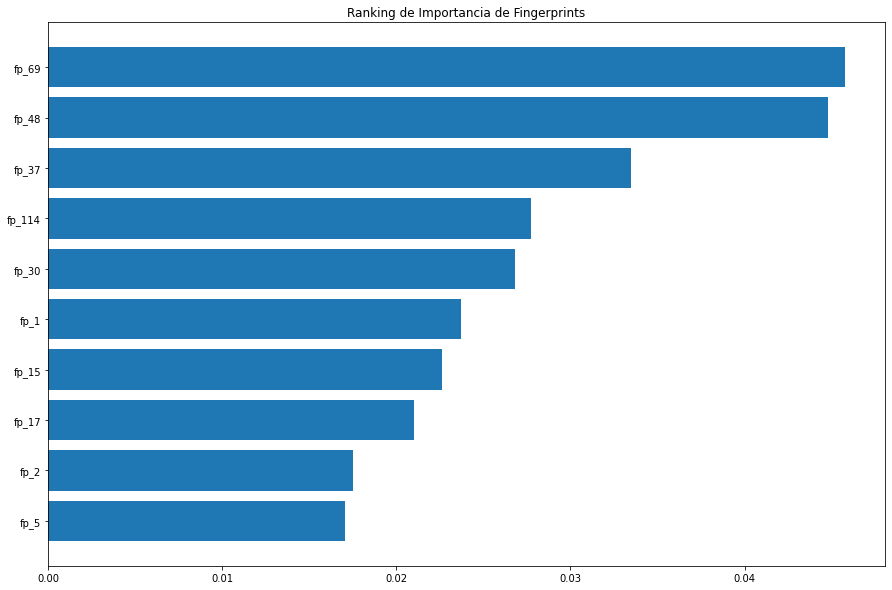

In [ ]:
# fimportance_dict = dict(zip(features_RDKit_fp.columns, rfc.feature_importances_))  #fingerprints + descriptores
fimportance_dict = dict(zip(fp_dataframe.columns, rfc.feature_importances_)) #Si solo usa fingerprints
# fimportance_dict = dict(zip(descriptoresRDKit.columns, rfc.feature_importances_)) #Si solo usa descriptores
sorteddata = sorted(fimportance_dict.items(), key=lambda x:-x[1])
topvalues = [x[1] for x in sorteddata][:10]
topfeaturesrank = [x[0] for x in sorteddata][:10] # Para cuando usamos fingerprints o fp + descriptores
# topfeaturesrank = descriptors_name[:10] #Solo descriptores, y el de desc + fp

fig, ax = plt.subplots(figsize= [15, 10])
ax.barh(np.arange(10), topvalues, align='center')
ax.set_yticks(np.arange(10))
ax.set_yticklabels(topfeaturesrank)
ax.invert_yaxis()
#ax.set_xlabel('')
ax.set_title('Ranking de Importancia de Fingerprints')
plt.show()

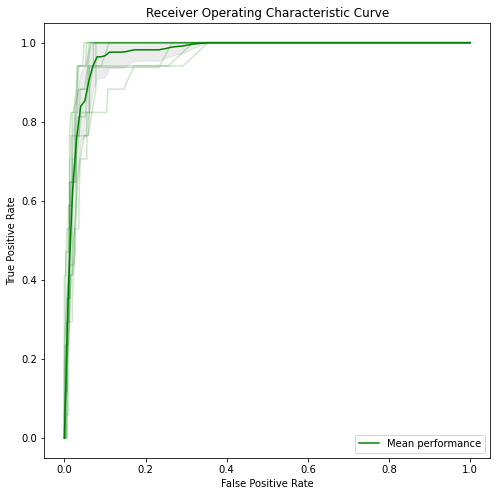

In [ ]:
# PLOTEAR CURVA ROC PROMEDIO CON SOMBREADO
  
fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(10):
  fpr1 = fpr_tprs[i][0]
  tpr1 = fpr_tprs[i][1]
  ax.plot(fpr1, tpr1, color='green', alpha=.2)
  interp_tpr = np.interp(mean_fpr, fpr1, tpr1)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
ax.plot(mean_fpr, mean_tpr, color='green', label="Mean performance")

# std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic Curve")
ax.legend(loc="lower right")
plt.show()

#    Moléculas con fingerprint 18

In [ ]:
from PIL import Image   
from rdkit import Chem
from matplotlib.colors import ColorConverter

def onehotplot(molnum, feature_bit, idsearch=1, molSize=(200,200)):
    
    mol = mols2[molnum]
           
    bitInfotemp={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bitInfotemp, useFeatures=True)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    # print(np.nonzero(arr)) 

    color = ColorConverter().to_rgb("tab:orange") #Elegir color

    atomID,radius = bitInfotemp.get(feature_bit)[idsearch-1]
    
    mc = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()        
    
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        bondsToUse=[]

        for bond in env:
            atomsToUse.append(mol.GetBondWithIdx(bond).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(bond).GetEndAtomIdx())
            bondsToUse.append(bond)

        atomsToUse = list(set(atomsToUse))
        bondsToUse = list(set(bondsToUse))

    else:
        atomsToUse = [atomID]
        bondsToUse=[]

    atomcolors={x:color for x in atomsToUse}
    bondcolors={x:color for x in bondsToUse}
    atomsradii={x:0.27 for x in atomsToUse} #Ajustar diametro del sombreado de los atoms

    drawer.DrawMolecule(mc, highlightAtoms=atomsToUse,
                        highlightBonds=bondsToUse,
                        highlightAtomColors=atomcolors,
                        highlightBondColors=bondcolors,
                        highlightAtomRadii=atomsradii)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')

    return display(SVG(svg))
  
# onehotplot(6456, 1008)

[ 322  497  959 1037 1511 3193 3194 4718 4738 6298]
Flavors: ['bitter']


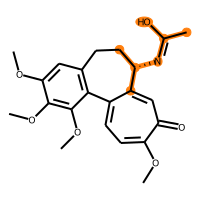

Flavors: ['clean', 'fresh', 'leaf', 'lily', 'rose', 'violet']


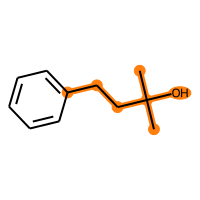

Flavors: ['meat', 'roast']


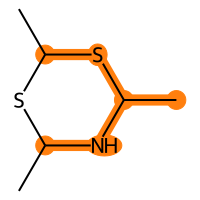

Flavors: ['bitter']


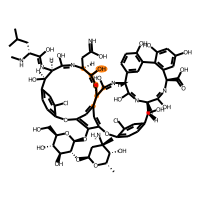

Flavors: ['anise', 'earth', 'fresh', 'sweet']


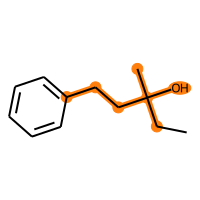

Flavors: ['cocoa', 'meat', 'peanut']


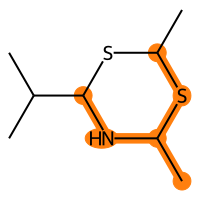

Flavors: ['cocoa', 'peanut', 'roast']


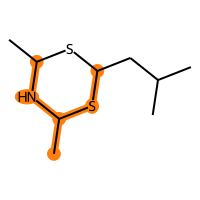

Flavors: ['sweet']


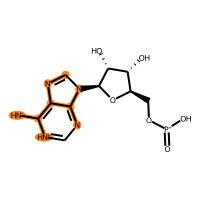

Flavors: ['sweet']


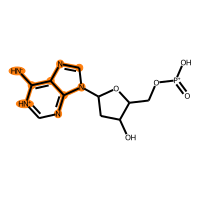

Flavors: ['sweet']


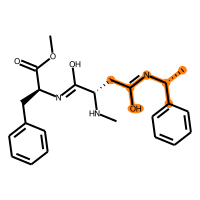

In [ ]:
fp = 69
indices_fp_n = fp_dataframe[(fp_dataframe['fp_'+str(fp)] == 1)].index[:10] #Me devuelve qué moléculas tienen fingerprint 18, pruebo con los primeros diez nomás
mol_fp_n = indices_fp_n.values #Convierto a array
print(mol_fp_n)

for i in mol_fp_n:
  #print(data.iloc[i,:].common_name)
  print('Flavors:',oneHot_2.columns[np.nonzero(oneHot_2.iloc[i, 0: -1].values)].values.tolist())
  onehotplot(i,fp)

In [ ]:
#for i in mol_fp_18:
#  mol = mols2[i]       
#  bitInfotemp={}
#  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bitInfotemp, useFeatures=True)
#  arr = np.zeros((1,))
#  DataStructs.ConvertToNumpyArray(fp, arr)
#
#  print(i, bitInfotemp)

# Modelo 2: Clustering

In [ ]:
N_clusters = 4

seed = 298

# X_full = features_sin_solo_sweet.to_numpy() # descriptores + fingerprints (sin moleculas con unico tag sweet)
# X_full = descriptores_sin_solo_sweet
# X_full = fingerprints_sin_solo_sweet
# freq_flavor_dict2 = freq_flavor_dict_sin_sweet # para cuando se usa los features sin solo sweets
# oneHot3 = oneHot_sin_sweet                     # para cuando se usa los features sin solo sweets

oneHot3 = oneHot_2
freq_flavor_dict2 = freq_flavor_dict 

X_full = features_RDKit_fp.to_numpy() # Descriptores + fingerprints
# X_full = fp_dataframe.to_numpy() # Solo fingerprints
# X_full = descriptoresRDKit.to_numpy() # Solo Descriptores

pca = PCA(n_components = 100,random_state = seed)
pca.fit(X_full)
X = pca.transform(X_full)

scaler = MinMaxScaler()
scaler.fit(X) 
X = scaler.transform(X)

#Metodo Kmeans
kmeans = KMeans(n_clusters=N_clusters,random_state = seed)
labels = (kmeans.fit(X)).labels_

#Metodo Jerarquico
# cluster = AgglomerativeClustering(n_clusters=N_clusters, affinity='euclidean', linkage='ward')
# labels = cluster.fit_predict(X)  # fit_predict hace lo mismo que fit pero devuelve el vector de etiquetas de las samples

np.unique(labels, return_counts=True) 


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:542: RuntimeWarning: overflow encountered in square
  self.explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:550: RuntimeWarning: invalid value encountered in double_scalars
  self.explained_variance_.sum())


(array([0, 1, 2, 3], dtype=int32), array([ 1784,  5544,  5653, 12124]))

Cluster  0   1784 [(0.07762, 'sweet'), (0.03704, 'bland'), (0.03523, 'bitter'), (0.01923, 'metal'), (0.0119, 'mild'), (0.0073, 'balsam'), (0.00613, 'odorless'), (0.00483, 'fat'), (0.00465, 'spicy'), (0.00141, 'leaf')]
Cluster  1   5544 [(0.24286, 'sweet'), (0.07407, 'bland'), (0.06135, 'odorless'), (0.05827, 'bitter'), (0.01724, 'vanilla'), (0.0119, 'mild'), (0.00148, 'fruit')]
Cluster  2   5653 [(1.0, 'wine'), (1.0, 'weedy'), (1.0, 'wax'), (1.0, 'warm'), (1.0, 'violet'), (1.0, 'vegetable'), (1.0, 'tropicall'), (1.0, 'tonka'), (1.0, 'tomato'), (1.0, 'tobacco'), (1.0, 'terpene'), (1.0, 'tea'), (1.0, 'sweat'), (1.0, 'sulfur'), (1.0, 'strong'), (1.0, 'strawberry'), (1.0, 'solvent'), (1.0, 'soap'), (1.0, 'sharp'), (1.0, 'savory'), (1.0, 'rum'), (1.0, 'rotten'), (1.0, 'rose'), (1.0, 'raspberry'), (1.0, 'rancid'), (1.0, 'pungent'), (1.0, 'powerful'), (1.0, 'powdery'), (1.0, 'potato'), (1.0, 'plum'), (1.0, 'plastic'), (1.0, 'pineapple'), (1.0, 'pine'), (1.0, 'phenol'), (1.0, 'peppermint'), (1

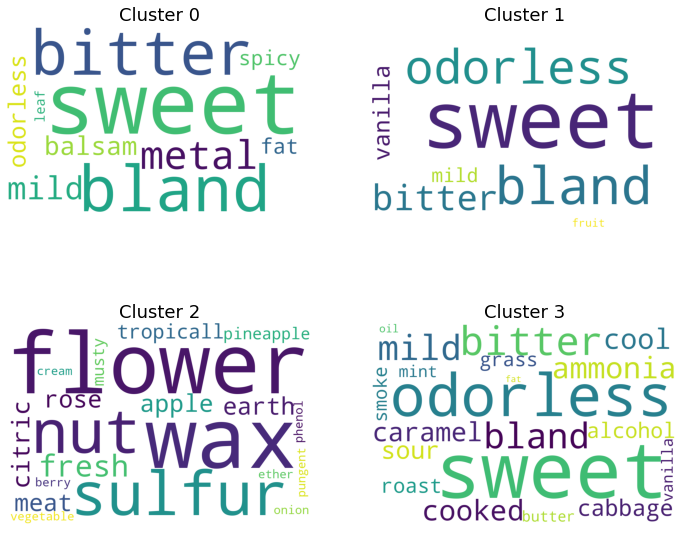

In [ ]:
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

fig, axs = plt.subplots((N_clusters+1)//2, 2, figsize = (12,10))

clusters = []
for i in range(N_clusters):
  index = np.nonzero(labels==i)[0]
  flavors_i = oneHot3.iloc[index,:-1].apply(pd.value_counts)[1:].T.sort_values(by=1, ascending = False).dropna().to_dict()[1]
  flavors_i_norm = {k: v/freq_flavor_dict2[k] for k, v in flavors_i.items()}
  # print('Cluster ', str(i), ' ', len(index), flavors_i)
  print('Cluster ', str(i), ' ', len(index), sorted( ((round(v,5),k) for k,v in flavors_i_norm.items()), reverse=True))
  clusters.append([x[1] for x in sorted( ((round(v,5),k) for k,v in flavors_i_norm.items()), reverse=True)])

  wc = WordCloud(**wc_atributos).generate_from_frequencies(flavors_i_norm)
  
  if(N_clusters == 2):
    axs[i%2].set_title('Cluster '+ str(i), fontsize=18)
    axs[i%2].imshow(wc)
    axs[i%2].axis('off')
  else:
    axs[i//2,i%2].set_title('Cluster '+ str(i), fontsize=18)
    axs[i//2,i%2].imshow(wc)
    axs[i//2,i%2].axis('off')

primeros_n = 8

print('\n',indice_falopa_clusters(clusters,primeros_n))

i = 0
for cluster in clusters:
  print('Cluster ',i, similaridad_de_cluster(cluster,primeros_n))
  i += 1

for par in combinations(range(len(clusters)),2):
  print(par[0],"vs",par[1],":",similaridad_entre_clusters(clusters[par[0]],clusters[par[1]],primeros_n))

# Buscador de clusters

In [ ]:
N_clusters = 6

X_full = features_sin_solo_sweet.to_numpy() # descriptores + fingerprints (sin moleculas con unico tag sweet)
# X_full = descriptores_sin_solo_sweet
# X_full = fingerprints_sin_solo_sweet
freq_flavor_dict2 = freq_flavor_dict_sin_sweet # para cuando se usa los features sin solo sweets
oneHot3 = oneHot_sin_sweet                     # para cuando se usa los features sin solo sweets

seeds = np.arange(100,500)

seed_dic = {}

for seed in seeds:

  print(seed)

  pca = PCA(n_components = 100, random_state = seed)
  pca.fit(X_full)
  X = pca.transform(X_full)

  scaler = MinMaxScaler()
  scaler.fit(X) 
  X = scaler.transform(X)

  #Metodo Kmeans
  kmeans = KMeans(n_clusters=N_clusters, random_state = seed)
  labels = (kmeans.fit(X)).labels_


  clusters = []
  for i in range(N_clusters):
    index = np.nonzero(labels==i)[0]
    flavors_i = oneHot3.iloc[index,:-1].apply(pd.value_counts)[1:].T.sort_values(by=1, ascending = False).dropna().to_dict()[1]
    flavors_i_norm = {k: v/freq_flavor_dict2[k] for k, v in flavors_i.items()}
    clusters.append([x[1] for x in sorted( ((round(v,5),k) for k,v in flavors_i_norm.items()), reverse=True)])

  primeros_n = 8

  seed_dic[seed] = indice_falopa_clusters(clusters,primeros_n)

print(seed_dic)


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


In [ ]:
sorted( ((v,k) for k,v in seed_dic.items()), reverse=True)[:10]

[(2.1239879653826694, 476),
 (2.0526037549762655, 119),
 (2.044507524978137, 328),
 (1.9603674325258194, 223),
 (1.9568271149132603, 418),
 (1.9359347271896665, 286),
 (1.8867790722307278, 115),
 (1.8849901865534233, 468),
 (1.8724118070136986, 464),
 (1.861567193377075, 460)]